In [1]:
import numpy as np
import scanpy as sc
import sys
sys.path.append('/homefolder/deborah/Git/Spatial_transcriptomics_rep/src')
from _utils import make_AnnData
sc.settings.verbosity = 3     
import random
random.seed(0)
np.random.seed(0)

Read the spatial data

In [2]:
cell_by_gene_csv = '/TestVol/vizgen/202312081546_HuOvarianCa-1317546B-VS176-NP_VMSC12002/region_0/Cellpose_DAPI_CB3/cellpose_cell_by_gene.csv'
meta_cell_csv = '/TestVol/vizgen/202312081546_HuOvarianCa-1317546B-VS176-NP_VMSC12002/region_0/Cellpose_DAPI_CB3/cellpose_cell_metadata.csv'

Vizgen function for reading the data

In [3]:
adata = make_AnnData(cell_by_gene_csv, meta_cell_csv)
# Filtering out blank genes
adata = adata[:, adata.var_names.str.startswith('Blank-')==False]

# Storing the counts for later use
adata.layers["counts"] = adata.X.copy()

adata

The indices in cell_by_gene and cell_metadata match.


/homefolder/deborah/miniconda3/envs/scgen/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_8973/96395168.py:6: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


AnnData object with n_obs × n_vars = 763588 × 361
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'barcodeCount'
    obsm: 'spatial'
    layers: 'counts'

Preprocessing

<Axes: >

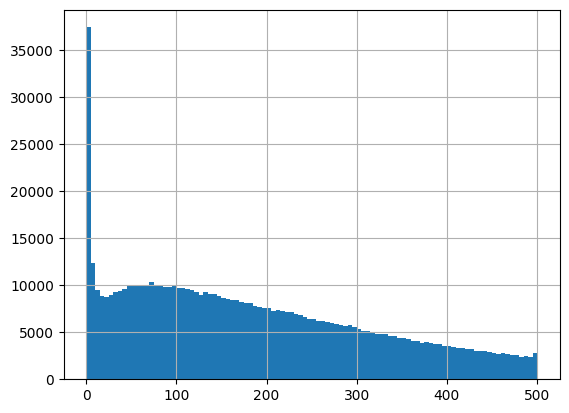

In [4]:
adata.obs.barcodeCount.hist(bins=100,  range= [0,500]) # Gene expression count

<Axes: >

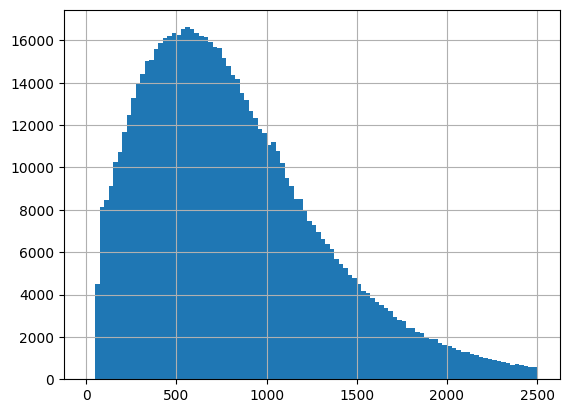

In [5]:
adata.obs.volume.hist(bins=100, range= [0,2500]) # Volume distribution

Cell filteringg based on count and volume

In [6]:
# set the threshold
min_barcode_count_threshold = 20
volume_upper_threshold = 2500
volume_lower_threshold = 100

selectCells = adata.obs[(adata.obs.volume < volume_upper_threshold)
                   & (adata.obs.volume > volume_lower_threshold)
                   & (adata.obs.barcodeCount > min_barcode_count_threshold)].index

In [7]:
adata = adata[selectCells].copy()


Normalize barcode ounts by cell volume: This enables to account for different cutting angles and areas. Normalization to median cell volume. 

In [8]:
adata.obs['volume_factor'] = adata.obs['volume']/np.median(adata.obs['volume'])
t = np.divide(adata.X, np.array(adata.obs['volume_factor']).reshape(-1, 1))
adata.X = t

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


Storing the raw data

In [10]:
adata.raw = adata

Scaling the data

In [11]:
sc.pp.scale(adata, max_value=10)

Dimentaion reduction

computing PCA
    with n_comps=50
    finished (0:00:58)


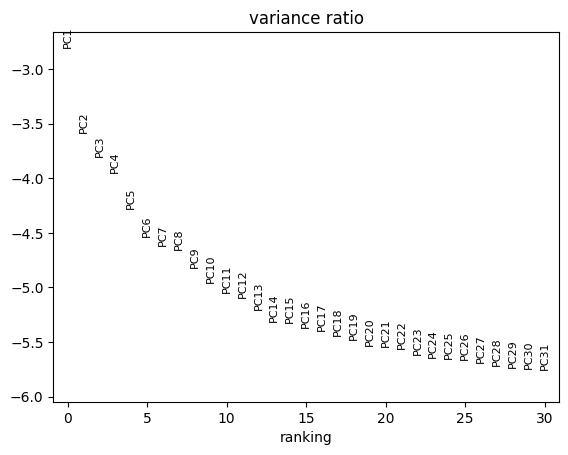

In [12]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True) # use elbow plot to determine the number of PCs

In [13]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=15)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:06:45)


In [14]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:48:44)


Visualization

/homefolder/deborah/miniconda3/envs/scgen/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


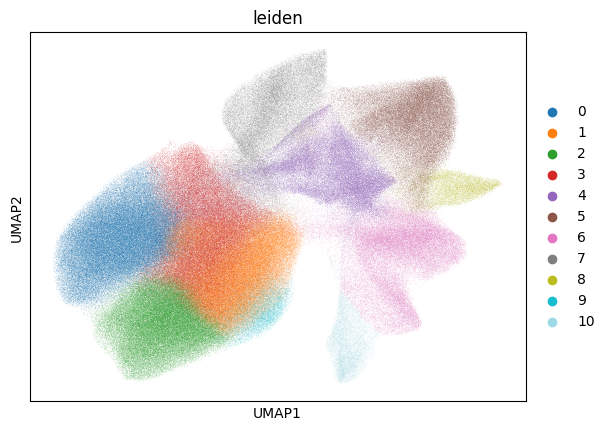

In [15]:
sc.pl.umap(adata, color="leiden",palette ='tab20')

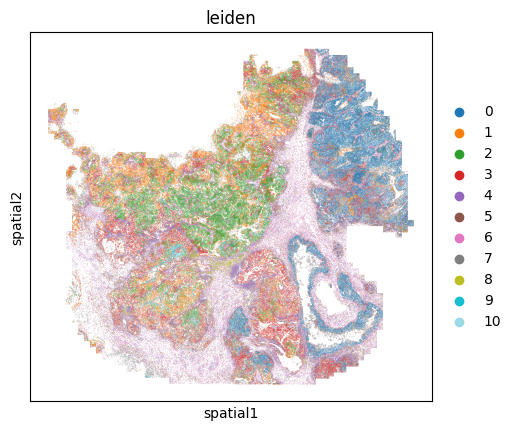

In [16]:
sc.pl.spatial(adata, color='leiden', spot_size=10)